# **TOPIC EXTRACTION using LDA TOPIC MODELING**


---
**ANALYZING AMAZON PRODUCT REVIEWS**


Considering **Xbox** and **PlayStation** brands, we aim to extract main topics discussed in Amazon reviews regarding two of the most recent products of each brand:
- *Xbox Series X* and *Xbox One S* for Microsoft Xbox
- *PS4* and *PS5* for Sony PlayStation

The analysis is based on the following approach:

- we try to better understand the data with `Exploratory Data Analysis`
- we apply topic modeling `LDA` algorithm
- we inspect and analyze topics with many visualizations, such as `WordClouds`, `topic distributions`, `count plots`
- we filter reviews on certain topics or words to better understand some concepts.

#Import

In [ ]:
!pip install pyLDAvis

In [ ]:
from google.colab import drive
import time
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import wordcloud
from wordcloud import WordCloud
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn

#Mount Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Set parameters
- `path` path to the project folder, \
  **please check that is correct !**

- `using_title` if true means that we are passing to our model the concatenation between the title and the text of the review. This may be important since most of the time the title is somehow a recap of the content of the review.

- `using_dataset` contains the name of the dataset we want to analyze, between xbox one, xbox series, ps4, ps5.

- `LANGUAGE` identify the language of reviews

- `more_info` if true prints more information during execution.

- `selected_topics` and `selected_lr` are parameters you can set to customize LDA parameters without searching for best ones

In [ ]:
## General path
# Change this path according to where the project's folder is located
path = '/content/drive/MyDrive/'

## If you want to use also the title concatenated with the text
using_title = True

#------------------------------------------------------------------
## Choosing a dataset to analyze
# 0 -> ps4
# 1 -> ps5
# 2 -> xbox one
# 3 -> xbox series
which_dataset = 3

#-------------------------------------------------------------------
#Choosing a language between 'english', 'spanish'
LANGUAGE = 'english'

#-------------------------------------------------------------------
# Set this variable to True if you want more information to be print
more_info = False

#-------------------------------------------------------------------
# If set to an integer number it will force the LDA topics to be as  
# the number selected, if set to None or 0 it will be search using 
# Grid search the best parameters
# Note: if you select a specific number of topics you need to select 
# also a learning rate
selected_topics = 2
selected_lr = 0.7

if selected_topics or selected_topics == 0: 
  if not isinstance(selected_lr, float): raise AssertionError('You have set costumize number of topics so selected_lr must be set as well!!')

## Loading dataset

In [ ]:
# Set global seed
SEED = 42 # The Answer to the Ultimate Question of Life, The Universe, and Everything.
np.random.seed(SEED)

dataset_product = ['ps4', 'ps5', 'xbox one', 'xbox series']
using_dataset = dataset_product[which_dataset]

# Set preorder and publish date of products
if using_dataset == 'xbox series': 
  preorder_date = '20200922'
  published_date = '20201110'
elif using_dataset == 'ps5':
  preorder_date = '20200922'
  published_date = '20201112'
else: # It does not matter, we have recent reviews (2018)
  preorder_date = None 
  published_date = None 

# Setting parameters for tf-idf 
if using_dataset == 'xbox one':
  MIN_FREQ = 10
  MAX_FREQ = 1   # Default
else:
  MIN_FREQ = 3
  MAX_FREQ = 0.7

# Defining sub paths  
data_folder= path + 'Project_Data_Mining/Data/'
amazon_folder = data_folder + 'Amazon/preprocessed_dataset/'
amazon_folder_original = data_folder + 'Amazon/clean_dataset/'

##  XBOX SERIES X 
if using_dataset == 'xbox series': 
  a_df = pd.read_csv(amazon_folder + 'preprocessed_scraped_reviews_Xbox_series_X.csv')
  a_original_df = pd.read_csv(amazon_folder_original + 'clean_scraped_reviews_Xbox_series_X.csv')

##  XBOX ONE S REVIEWS 
elif using_dataset == 'xbox one':
  a_df = pd.read_csv(amazon_folder + 'preprocessed_scraped_reviews_Xbox1_S.csv')
  a_original_df = pd.read_csv(amazon_folder_original + 'clean_scraped_reviews_Xbox1_S.csv')

##  PS4 AND PS5 REVIEWS
else:
  a_df = pd.read_csv(amazon_folder + 'preprocessed_scraped_reviews_'+using_dataset+'.csv')
  a_original_df = pd.read_csv(amazon_folder_original + 'clean_scraped_reviews_'+using_dataset+'.csv')

print('\n\n---- AMAZON DATASET : ', using_dataset, ' ----')
print('Loaded ', a_df['text'].count(), ' preprocessed reviews, ', a_original_df['text'].count(), 'cleaned reviews.')
first_date = str(a_df['date'].iloc[0])
last_date = str(a_df['date'].iloc[-1])
print('Reviews from ', first_date[-2:]+'/'+first_date[4:6]+'/'+first_date[0:4], ' to ', \
      last_date[-2:]+'/'+last_date[4:6]+'/'+last_date[0:4])
print('Columns : ', list(a_df.columns))



---- AMAZON DATASET :  xbox series  ----
Loaded  596  preprocessed reviews,  599 cleaned reviews.
Reviews from  25/11/2020  to  10/12/2020
Columns :  ['id', 'name', 'score', 'title', 'place', 'date', 'verified purch', 'text', 'upvotes', 'language']


## Cleaning dataset

Dealing with **missing values** (there are empty texts)

In [ ]:
if a_df['text'].isnull().values.any() == True:
  print("Shape before dropping null values: ", a_df.shape)
  a_df = a_df.dropna(subset=['text'], axis=0)
  print("Shape after dropping null values: ", a_df.shape)

Remove the substring 'Your browser does not support HTML5 video.' from preprocessed texts: \
in some reviews users have used gif images or video and this string is due to a default error

In [ ]:
a_df['text'] = a_df['text'].apply(lambda x: x.replace('your browser support html5 vide', ''))
a_original_df['text'] = a_original_df['text'].apply(lambda x: x.replace(
    'Your browser does not support HTML5 video.  ', ''))

# Exploratory Data Analysis

We print some statistics in order to better understand our dataset.

In [ ]:
a_df.head()

,id,name,score,title,place,date,verified purch,text,upvotes,language
0,1,Amazon Customer,1,third wrong,the United States,20201125,False,this illeg what scummi thing,1418,english
1,2,duwyne,1,horribl,the United States,20201113,False,hope never sell,1734,english
2,3,Jose C,1,wait stock replenish,the United States,20201114,False,wait stock replenish game backward compat feed...,1313,english
3,4,Dustwaj,1,overpr,the United States,20201125,False,how dare amazon that cool dude,871,english
4,5,Jason Japa,1,overpr,the United States,20201125,False,annoy,793,english


In [ ]:
a_original_df.head()

,name,score,title,place,date,verified purch,text,upvotes,language
0,Amazon Customer,1,Third is wrong,the United States,20201125,False,This should be illegal. What a scummy thing ...,1418,english
1,duwyne,1,Horrible,the United States,20201113,False,Hope you never sell them,1734,english
2,Jose C,1,Wait for the stock to replenish,the United States,20201114,False,"Wait for the stock to replenish, all games a...",1313,english
3,Dustwaj,1,Overpriced,the United States,20201125,False,"How dare you Amazon! $1,500.00? Thats not ...",871,english
4,Jason Japa,1,Overpriced,the United States,20201125,False,annoying,793,english


## Some general statistics about data

In [ ]:
a_df.describe()

,id,score,date,upvotes
count,596.000000,596.000000,5.960000e+02,596.000000
mean,299.154362,4.127517,2.020252e+07,18.033557
std,172.969730,1.546103,3.226198e+03,123.743129
min,1.000000,1.000000,2.020111e+07,0.000000
25%,149.750000,4.000000,2.020111e+07,0.000000
50%,298.500000,5.000000,2.020113e+07,0.000000
75%,449.250000,5.000000,2.020122e+07,1.000000
max,599.000000,5.000000,2.021013e+07,1734.000000


Knowing in which country reviews were written

In [ ]:
a_df['place'].value_counts()

the United States     443
Canada                153
Name: place, dtype: int64

**Language of reviews** \
Considering different languages when doing Topic Modeling can introduce noise in the data and confuse the model, so we prefer to separately consider languages. \
We choose to use most common languages that are English and Spanish. \
Note that by changing parameter `LANGUAGE` you can filter the dataset using just `LANGUAGE` samples 

Overview of different languages on the dataset

In [ ]:
a_df['language'].value_counts()

english                 581
french                   12
spanish                   2
chinese (simplified)      1
Name: language, dtype: int64

Filtering the dataset according to the `LANGUAGE` parameter

In [ ]:
a_df = a_df.loc[a_df['language'] == LANGUAGE]
a_df.head()

,id,name,score,title,place,date,verified purch,text,upvotes,language
0,1,Amazon Customer,1,third wrong,the United States,20201125,False,this illeg what scummi thing,1418,english
1,2,duwyne,1,horribl,the United States,20201113,False,hope never sell,1734,english
2,3,Jose C,1,wait stock replenish,the United States,20201114,False,wait stock replenish game backward compat feed...,1313,english
3,4,Dustwaj,1,overpr,the United States,20201125,False,how dare amazon that cool dude,871,english
4,5,Jason Japa,1,overpr,the United States,20201125,False,annoy,793,english


## Time series

Ordering the dataset in time order aka a time series

In [ ]:
timeseries_df = a_df.sort_values('date')
timeseries_df.head()

,id,name,score,title,place,date,verified purch,text,upvotes,language
179,180,Linsey Payne,5,whi would u buy lol,the United States,20201110,True,amaz,1,english
32,33,The Du,1,power cord work,the United States,20201110,True,releas day power cord event work power cycl 3 ...,22,english
34,35,Trenton P Mongillo,5,amaz new game one system microsoft,the United States,20201110,True,everyth youv come expect consol launch polish ...,14,english
35,36,Amazon Customer,1,crap product,the United States,20201110,True,it even turn play 20 min power button work wha...,20,english
199,200,Tomeeka barnett,5,got time,the United States,20201110,True,got mine time cant wait play thing 5 plus year,2,english


plotting the number of reviews for each day, note that if `preorder_date` and `publish_date` are defined then you'll see them in the plot figure colored differently

<Figure size 432x288 with 0 Axes>

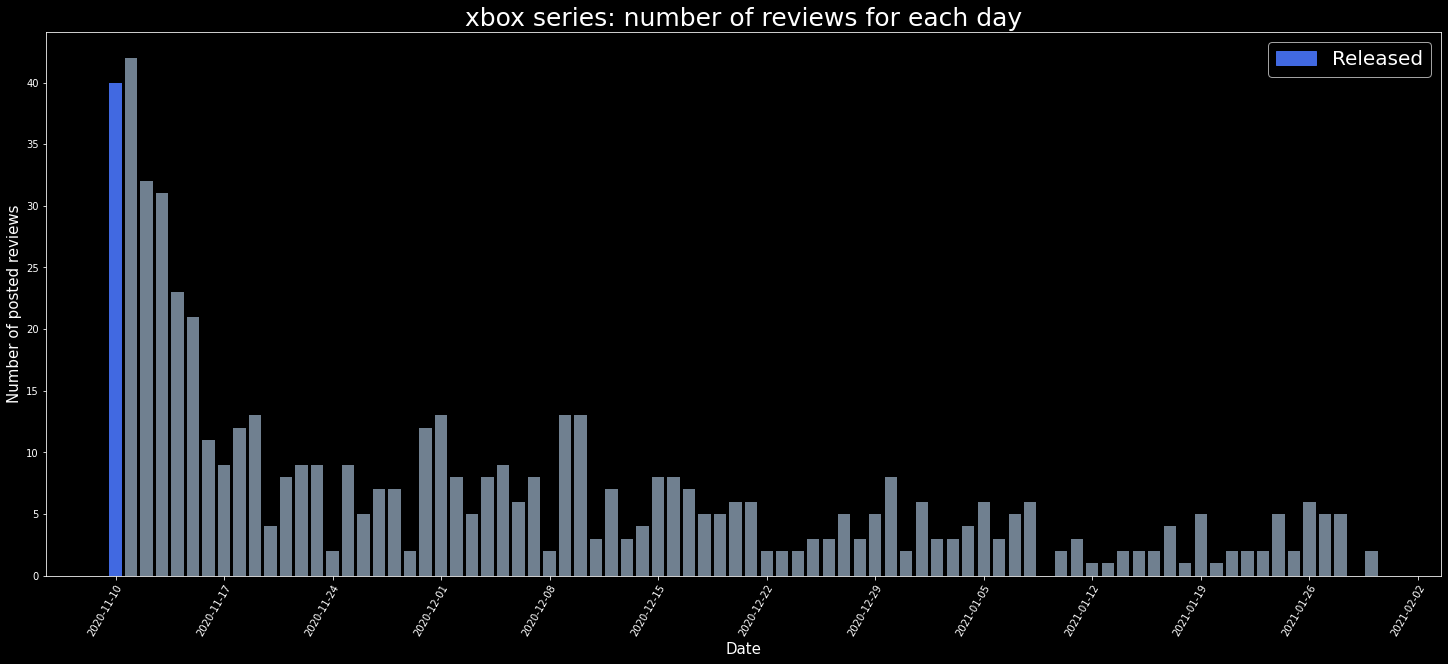

In [ ]:
def create_dict_color(preorder_date = None, publish_date = None):
    dict_color = {}
    if preorder_date: dict_color[preorder_date] = 'darkmagenta'
    if publish_date: dict_color[publish_date] = 'royalblue'
    return dict_color

def print_time_series(df_datatime, preorder = None, published = None, additional_text = None):
  new_df = pd.DataFrame(df_datatime.apply(lambda x:str(x)).value_counts())
  new_df.reset_index(inplace=True)
  new_df = new_df.rename(columns = {'date':'count', 'index':'datatime'}).sort_values('datatime')
  color_map = create_dict_color(preorder, published)
  clrs = [color_map.get(x,'slategray') for x in new_df.datatime]
  if len(clrs) > 80:
    interval = int((len(clrs)-80)/40)
  else:
    interval = 1
  new_df.datatime = pd.to_datetime(new_df.datatime)
  plt.figure()
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(25,10))
  ax.bar(new_df.datatime, new_df['count'], color=clrs)
  # Define the date format
  date_form = DateFormatter("%Y-%m-%d")
  ax.xaxis.set_major_formatter(date_form)
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
  # Set title and labels for axes
  if additional_text: ax.set_title(additional_text+': number of reviews for each day', fontsize=25)
  else: ax.set_title('Number of reviews for each day', fontsize=25)
  ax.set_xlabel("Date", fontsize=15)
  ax.set_ylabel("Number of posted reviews", fontsize=15)
  if preorder and published:
    custom_legend = []
    if 'darkmagenta' in clrs: custom_legend.append(mpatches.Patch(color='darkmagenta', label='Preorder'))
    if 'royalblue' in clrs: custom_legend.append(mpatches.Patch(color='royalblue', label='Released'))
    ax.legend(handles = custom_legend, loc="upper right", fancybox = True, fontsize = 20)
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
  plt.show()

# print time series
print_time_series(timeseries_df['date'], preorder_date, published_date, using_dataset)

## Analyzing reviews by ratings

Analyzing reviews ratings

In [ ]:
a_df['score'].value_counts().sort_index()

1    104
2      8
3     14
4     38
5    417
Name: score, dtype: int64

<Figure size 432x288 with 0 Axes>

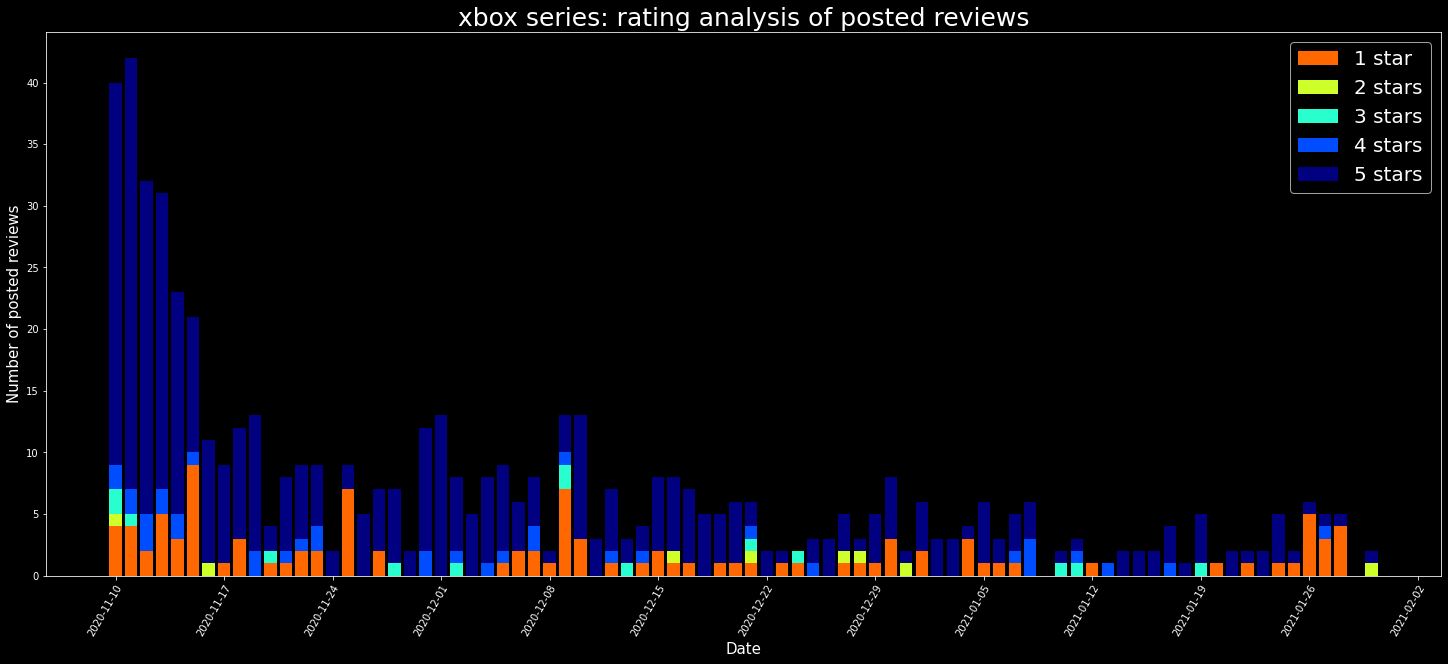

In [ ]:
def plot_average_sentiment(df_sa, additional_text = None):
  df_sa = pd.DataFrame(df_sa).rename(columns = {'score':'count'})
  df_sa.reset_index(inplace=True)
  for i in df_sa['date']:
    for j in range(1,6): 
      if not ((df_sa['date'] == i) & (df_sa['score'] == j)).any():
        df_sa = df_sa.append({'date':i, 'score':j, 'count':0}, ignore_index=True)
  
  df_sa = df_sa.sort_values(by=['date','score'])
  df_sa.date = pd.to_datetime(df_sa.date.apply(lambda x:str(x)))
  plt.figure()
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(25,10))
  new_colors = [plt.get_cmap('jet')(1. * i/5) for i in range(5)]
  new_colors.sort(reverse = True)
  dict_color_label_start = { 1: ['1 star', new_colors[0], None],
                      2: ['2 stars',new_colors[1], df_sa.loc[df_sa['score'] == 1]['count']],
                      3: ['3 stars',new_colors[2], df_sa.loc[df_sa['score'] <= 2].groupby(['date'])['count'].sum()],
                      4: ['4 stars',new_colors[3], df_sa.loc[df_sa['score'] <= 3].groupby(['date'])['count'].sum()],
                      5: ['5 stars',new_colors[4], df_sa.loc[df_sa['score'] <= 4].groupby(['date'])['count'].sum()]
  }
  for i in dict_color_label_start.keys():
    y = df_sa.loc[df_sa['score'] == i]['count']
    ax.bar(df_sa.date.unique(), y, color=dict_color_label_start[i][1], label=dict_color_label_start[i][0], \
          bottom = dict_color_label_start[i][2])
  # Define the date format
  date_form = DateFormatter("%Y-%m-%d")
  ax.xaxis.set_major_formatter(date_form)
  if len(y) > 80:
    interval = int((len(y)-80)/40)
  else:
    interval = 1
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
  # Set title and labels for axes
  if additional_text: ax.set_title(additional_text+': rating analysis of posted reviews', fontsize=25)
  else: ax.set_title('Rating analysis of posted tweets', fontsize=25)
  ax.set_xlabel("Date", fontsize=15)
  ax.set_ylabel("Number of posted reviews", fontsize=15)
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
  plt.legend(loc="upper right",fancybox = True, fontsize = 20)
  plt.show()
  
plot_average_sentiment(a_df.groupby(['date','score'])['score'].count(), using_dataset)

Analizing reviews rating in correlation with the verified purchase information

In [ ]:
pd.crosstab(a_df['verified purch'], a_df['score'], margins=True)

score,1,2,3,4,5,All
verified purch,,,,,,
False,64,3,3,0,15,85
True,40,5,11,38,402,496
All,104,8,14,38,417,581


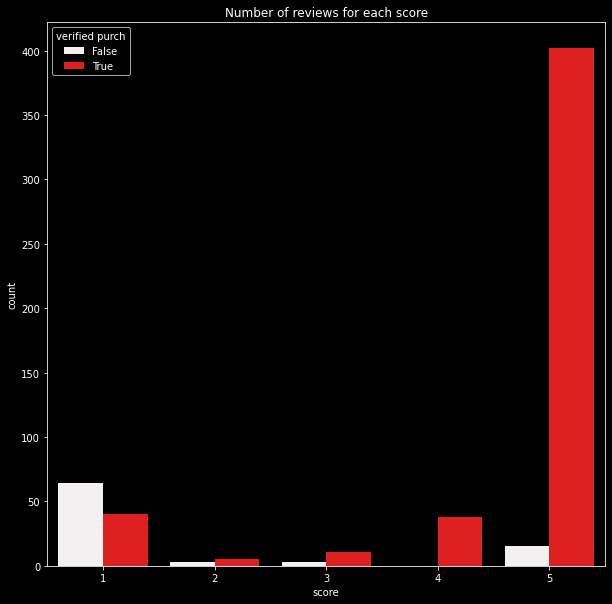

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Number of reviews for each score")
sns.countplot(x='score', hue='verified purch', data=a_df, color='red');

Our results show that the product has mostly received 5 stars. Moreover, most of the 5 stars reviews have verified purchase = True.

We can also try to understand how much the other customers agree on the given scores and reviews, using the information contained in the `upvotes`.

*   `amin` := minimum amount of votes received by a review with a certain score
*   `amax` := maximum amount of votes received by a review with a certain score
*   `mean` := average votes receive by reviews with a certain score




In [ ]:
a_df.groupby(['score'])['upvotes'].agg([np.mean, np.std, np.min, np.max])

,mean,std,amin,amax
score,,,,
1,89.846154,282.922226,0,1734
2,1.375000,1.767767,0,5
3,11.500000,36.764845,0,139
4,0.578947,1.445058,0,8
5,2.880096,21.787545,0,367


Then, we plot most frequent words of the reviews having a particular rating, for each rating.

We can notice that plotting wordclouds grouped by ratings is not enough to really understand what are the reviews about. We need a real model to focus on topics.

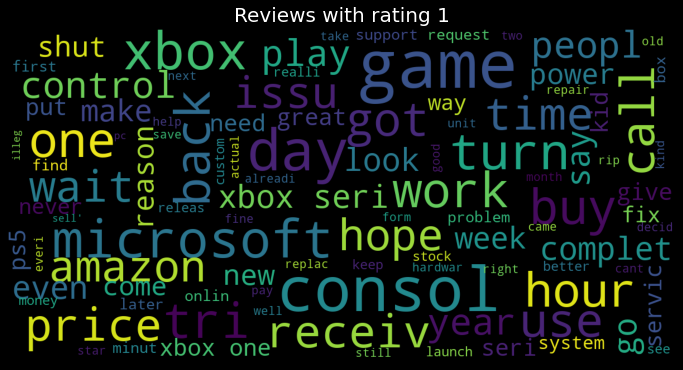

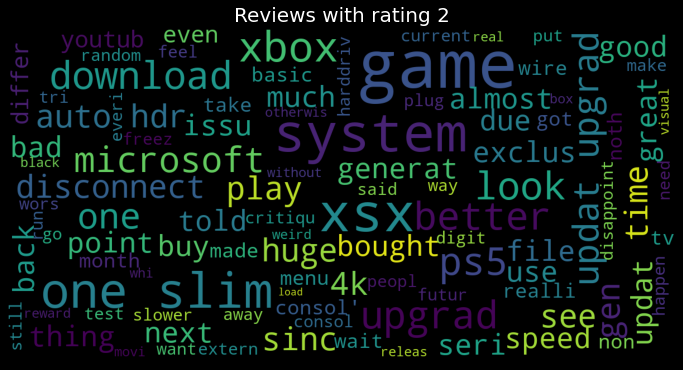

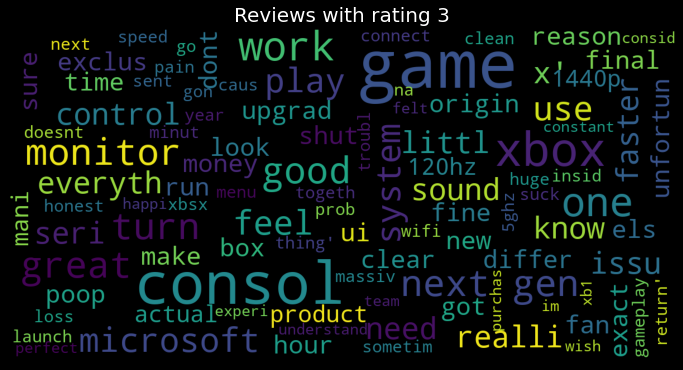

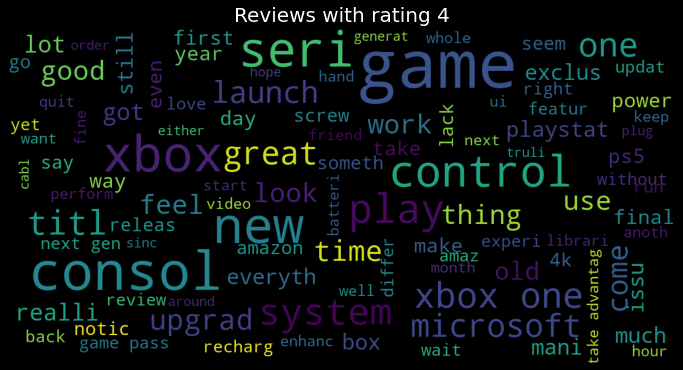

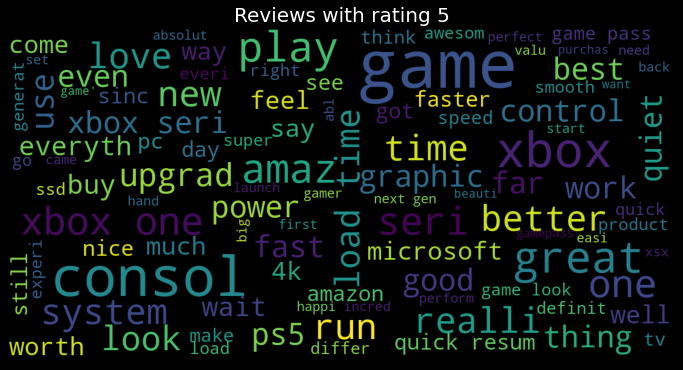

""


In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=100,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        plt.title(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    print("\n")

a_df.groupby('score').apply(
    lambda x: show_wordcloud(x.text.tolist(),title=f"Reviews with rating {x.score.tolist()[0]}")
)

# Topic modeling with LDA

`LDA` is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

## Vectorization

In [ ]:
if using_title:
  a_df['text'] = a_df['title'].fillna('') + " " + a_df['text']
  a_df.head()

In [ ]:
vec = TfidfVectorizer(min_df=MIN_FREQ, max_df=MAX_FREQ)

X_vectorized = vec.fit_transform(a_df['text'].fillna(""))

## Latent Dirichelet Allocation


*How to define the optimal number of topics?*\
**GridSearch** to select the optimal number of topics\
NOTE: Gives always the smaller n_components given as input

In [ ]:
def display_topics(model, feature_names, n_top_words, more_info):
    for topic_idx, topic in enumerate(model.components_):
        print("TOPIC %d:" % (topic_idx))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        if more_info:
          # relevance of the word to the topic
          print(", ".join([feature_names[i]+"("+str(topic[i])+")"
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
if not selected_topics or selected_topics == 0:
    %%time
    # Options to try with our LDA
    # Beware it will try *all* of the combinations, so it'll take ages
    search_params = {
      'n_components': [2, 3, 4, 5, 6, 10, 15, 20, 25],
      'learning_decay': [.2, .7]
    }

    # Set up LDA with the options we'll keep static
    model = LatentDirichletAllocation(learning_method='online', max_iter=50)

    # Try all of the options
    gridsearch = GridSearchCV(model, param_grid=search_params, n_jobs=-1, verbose=1)
    gridsearch.fit(X_vectorized)

    # What did we find?
    print("Best Model's Params: ", gridsearch.best_params_)
    print("Best Log Likelihood Score: ", gridsearch.best_score_)

Depending on how much detailed we want the topics to be, we choose the number of topics that LDA should identify.

In [ ]:
if selected_topics and selected_topics > 0:
    # taking selected parameters
    N_TOPICS = selected_topics
    LEARNING_DECAY = selected_lr
else:
    # taking parameters from best parameters computed by gridsearch
    N_TOPICS = gridsearch.best_params_['n_components']
    LEARNING_DECAY = gridsearch.best_params_['learning_decay']

MAX_ITER = 80
print('Number of topics: '+str(N_TOPICS))
print('Learning rate: '+str(LEARNING_DECAY))
print('Maximum number of iterations: '+str(MAX_ITER))

lda = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=MAX_ITER, learning_method='online', 
                                learning_offset=50., learning_decay=LEARNING_DECAY, 
                                random_state=SEED, verbose= 0 if not more_info else 1, evaluate_every=-1).fit(X_vectorized)

N_TOP_WORDS = 40
display_topics(lda, vec.get_feature_names(), N_TOP_WORDS, more_info)

# Lower the better. Perplexity = exp(-1. * log-likelihood per word)
# a lower perplexity implies data is more likely.
print("\nPerplexity: ", lda.perplexity(X_vectorized)) 

Number of topics: 2
Learning rate: 0.7
Maximum number of iterations: 80
TOPIC 0:
game, xbox, consol, love, seri, fast, one, it, the, amaz, time, good, system, load, play, get, far, look, power, realli, great, super, new, like, better, upgrad, work, control, day, next, gen, everyth, run, ps5, happi, quick, nice, worth, quiet, 4k
TOPIC 1:
great, product, awesom, consol, best, amazon, buy, price, perfect, work, beast, ever, scalper, peopl, overpr, hope, make, thank, this, amaz, insan, microsoft, get, what, came, expect, rip, never, month, year, would, machin, you, pay, got, that, sell, stock, preorder, next

Perplexity:  1034.8507394595376


## Topics visualization and interpretation

###`pyLDAvis` 
is a nice library to visualize topics of LDA.\
NOTE: Use light theme on Colab to better see this visualization

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, X_vectorized, vec)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.067062  0.0       1        1  73.970697
1     -0.067062  0.0       2        1  26.029303, topic_info=          Term       Freq      Total Category  logprob  loglift
332      great  22.000000  22.000000  Default  30.0000  30.0000
599    product   9.000000   9.000000  Default  29.0000  29.0000
75      awesom  10.000000  10.000000  Default  28.0000  28.0000
53      amazon   7.000000   7.000000  Default  27.0000  27.0000
121        buy   8.000000   8.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
473  microsoft   2.300049   5.990698   Topic2  -5.5024   0.3887
52        amaz   2.480529  15.505075   Topic2  -5.4269  -0.4867
317        get   2.277435  12.558309   Topic2  -5.5123  -0.3614
125       came   2.061644   6.070364   Topic2  -5.6118   0.2660
888       year   1.969637   4.380465   Topic2  -5.6575   0.5466

[120 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
18        1  0.931843      4k
52        1  0.838435    amaz
52        2  0.128990    amaz
53        1  0.136196  amazon
53        2  0.953374  amazon
...     ...       ...     ...
873       2  0.324165    work
885       1  0.971514    xbox
885       2  0.040480    xbox
888       1  0.456573    year
888       2  0.456573    year

[131 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

### WordCloud

`Wordcloud` visualization

Wordclouds help to highlight particular aspects of each topic, that may be useful for further analysis and inspections, and also they allow to capture the main semantic of the topic, giving an idea of what it is about.

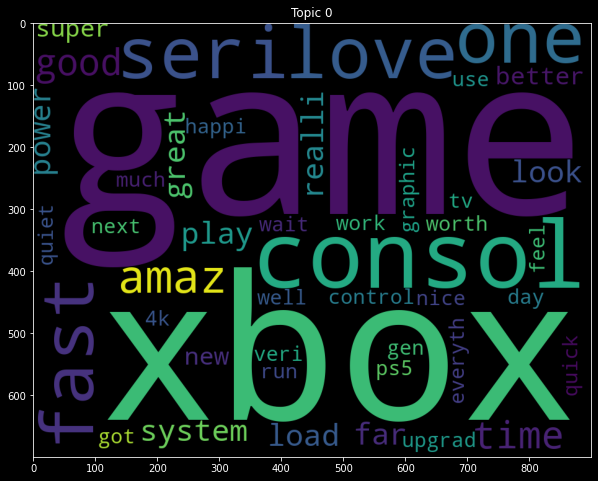

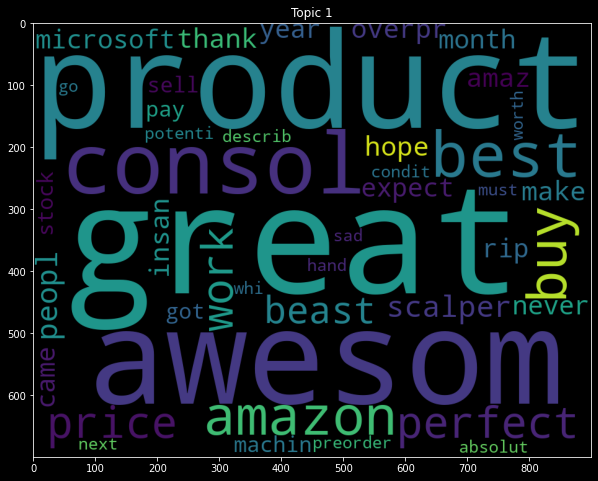

In [ ]:
# Generate a word cloud image for given topic
def draw_word_cloud(lda_model,index, vec):
  plt.style.use('dark_background')
  vocab = vec.get_feature_names()
  plt.figure(figsize=(10,10))  #important, otherwise you plot only last topic
  imp_words_topic=""
  comp=lda_model.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(background_color="black", contour_color='black', width=900, height=700).generate(imp_words_topic)
  plt.title('Topic '+str(index))
  #plt.imshow(wordcloud, interpolation='bilinear')
  plt.imshow(wordcloud)

for i in range(N_TOPICS):
  draw_word_cloud(lda, i, vec)

`Bar histogram` of top words in topics

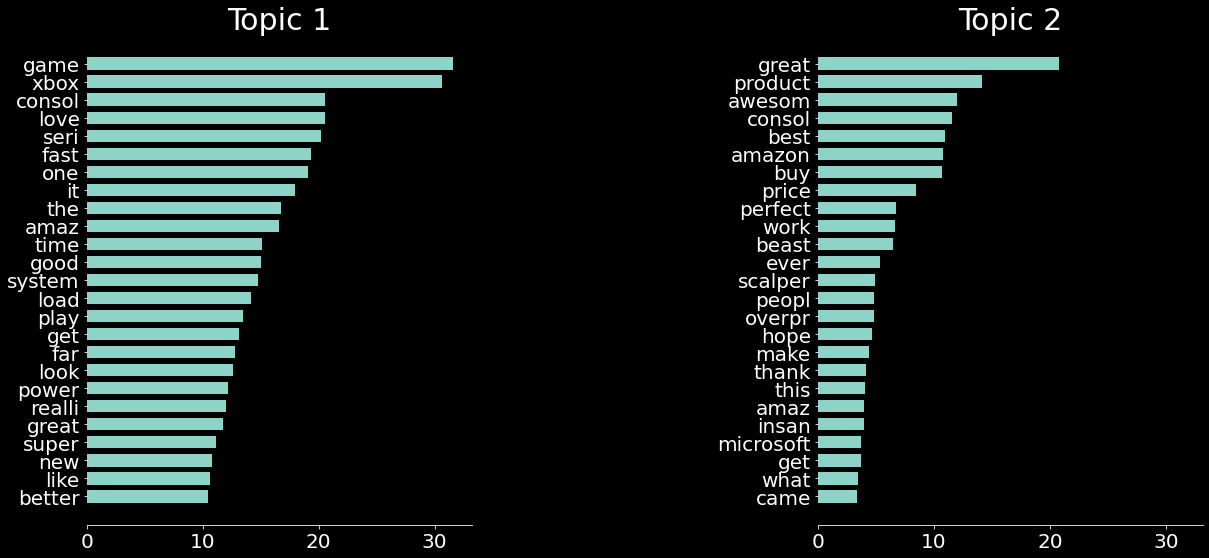

In [ ]:
# Generate a histogram for a given topic (see sklearn)
def draw_top_words_histogram(model, vectorizer, n_top_words, title, rows, cols):
  fig, axes = plt.subplots(rows, cols, figsize=(20, 8), sharex=True)
  axes = axes.flatten()
  feature_names = vec.get_feature_names()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
      fig.suptitle(title, fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

# if using_dataset == 'xbox series':
#   TOP_WORDS = 25
#   SUBPLOT_ROWS = 1
#   SUBPLOT_COLS = 2

# if using_dataset == 'ps5':
#   TOP_WORDS = 25
#   SUBPLOT_ROWS = 1
#   SUBPLOT_COLS = 3

TOP_WORDS = 25
SUBPLOT_ROWS = 1
SUBPLOT_COLS = N_TOPICS
draw_top_words_histogram(lda, vec, TOP_WORDS, "", SUBPLOT_ROWS, SUBPLOT_COLS)

To better understand the topics, we may want to **filter reviews** containing a particular **topic** (`show_reviews_by_topic`), and also filter by a specific **word** (`show_reviews_by_word`), for example, looking at the word '*suck*' we may want to understand why and what sucks in particular for our brand. 

In [ ]:
# These are the probabilities of belonging to each of the topics: doc_topic is a list of list
# example: doc 0 has doc_topic[0] = [0.2, 0.7, 0.1] 
# means that doc 0 contains topic 0 with probability 0.2, topic 1 with 0.7 and topic 2 with 0.1
doc_topic = lda.transform(X_vectorized)

##  This function is used to print all reviews that contain topic 'topic_id' with probability 'threshold'
def show_reviews_by_topic(doc_topic, topic_id, threshold):
  print("\n------Reviews of Topic #", topic_id, " with ", threshold, " probability:")
  for n in range(doc_topic.shape[0]):
    if doc_topic[n][topic_id] > threshold:
      id = a_df['id'].iloc[n]
      if a_original_df['title'].iloc[id-1] is not None:
        title = a_original_df['title'].iloc[id-1]
      else:
        title = ""
      print(n, " >> ", title, 
            " -", a_original_df['text'].iloc[id-1]) #ids start from 1, rows of dataframe start from 0

##  This function is used to get the most present and probable topic of the doc
def main_topic(doc_topic, doc_id):
  topic_most_pr = doc_topic[doc_id].argmax()  #most present topic
  return topic_most_pr

##  This function is used to print all reviews containing a paticular word
def show_reviews_by_word(doc_topic, word):
  print("\n------Reviews  containing '", word, "' :")
  for n in range(doc_topic.shape[0]):
    if (a_df.iloc[n])['text'].find(word) != -1:
      id = a_df['id'].iloc[n]
      if a_original_df['title'].iloc[id-1] is not None:
        title = a_original_df['title'].iloc[id-1]
      else:
        title = ""
      print(id, " (", a_df['upvotes'].iloc[n], " votes) >> ", title, 
            " -", a_original_df['text'].iloc[id-1]) #ids start from 1, rows of dataframe start from 0
      #print(n, " (topic #", main_topic(n), ") >> ", a_df['text'].iloc[n])

#If you want to print all main topic contained in each doc:
#for n in range(doc_topic.shape[0]):
  #print("doc: {} topic: {}\n".format(n,main_topic(n)))



Showing the most representative reviews for each topic

In [ ]:
#Show me the text of reviews having topic X at THRESHOLD % 

if using_dataset == 'xbox series':
  THRESHOLD = 0.93 #for XBOX SERIES
  show_reviews_by_topic(doc_topic, 0, THRESHOLD)
  THRESHOLD = 0.8 #for XBOX SERIES
  show_reviews_by_topic(doc_topic, 1, THRESHOLD)

#most representative reviews of topic 0
THRESHOLD = 0.91 #for XBOX ONE
show_reviews_by_topic(doc_topic, 0, THRESHOLD)

#most representative reviews of topic 1
THRESHOLD = 0.87 #for XBOX ONE
show_reviews_by_topic(doc_topic, 1, THRESHOLD)


------Reviews of Topic # 0  with  0.93  probability:
26  >>  Will only get better with software updates.  -   The size of the console is so compact, it runs whisper quiet and improves upon most backward compatible titles.4K HDR, 120 FPS, 1440P support, even Dolby vision is supported on the console.You will get about 800GB usable space from the SSD for your games. Eventually you may have to spill for the 1TB sea gate expansion card. However, the best thing to do is use a USB 3.0 external HDD for your older games and put the new games on your main SSD.Currently there is an issue with VRR via HDMI at 4K. Variable refresh rate on certain TVs like LG and Panasonic. Microsoft is aware and will patch this via a software update. In the meantime, you can either turn VRR off on your Xbox video settings or run it at 1440p/1080p which works fine.Gamepass is the best value in gaming right now, Destiny 2 and the new expansion are on it.UI is running butter smooth and games are launching instantly. 

In [ ]:
main_topics = []
for n in range(doc_topic.shape[0]):
  main_topics.append(main_topic(doc_topic, n))

#Add a column to dataframe with the main topic (most present topic in each review)
a_df['main_topic'] = main_topics
a_df.head()

,id,name,score,title,place,date,verified purch,text,upvotes,language,main_topic
0,1,Amazon Customer,1,third wrong,the United States,20201125,False,third wrong this illeg what scummi thing,1418,english,1
1,2,duwyne,1,horribl,the United States,20201113,False,horribl hope never sell,1734,english,1
2,3,Jose C,1,wait stock replenish,the United States,20201114,False,wait stock replenish wait stock replenish game...,1313,english,1
3,4,Dustwaj,1,overpr,the United States,20201125,False,overpr how dare amazon that cool dude,871,english,1
4,5,Jason Japa,1,overpr,the United States,20201125,False,overpr annoy,793,english,1


### Search by word

We may want to understand why in a certain topic a certain word (ex: '*bug*') is relevant and what it is about:

In [ ]:
##  USEFUL WORDS TO SEARCH FOR XBOX SERIES 
# Try 'rip', 'bug', 'suck', and also 'ps5' for competitor analysis

##  USEFUL WORDS TO SEARCH FOR XBOX ONE
# 'glitch', 'function', 'ridiculous', 'broken', 'problem'
# 'internet', 'hour', 'cord'

##  USEFUL WORDS TO SEARCH FOR PS5
# IF n_topics=3 'hilari', 'laugh'

##  USEFUL WORDS TO SEARCH FOR PS4
# 'wrong'
# IF n_topics=10 'power', 'cord', 'complaint',  'comparison'

show_reviews_by_word(doc_topic, 'code')


------Reviews  containing ' code ' :
379  ( 1  votes) >>  Blows Away The PS5  -   Why you may ask, well basically the only reason I've ever owned a Playstation, which I do like a lot is for it's amazing exclusives. No one can argue with it having the best! That being said the PS5 is nothing more than a glorified PS4 Pro, which i own and I'll keep until they don't support it anymore. Speaking of Pros here are the Pros and Cons of the Xbox Series, vs the PS5 and why it's much better imo.Pros.12 Teraflops as opposed to 10 tf in the PS5, many think this doesn't make a difference but for overall bandwith and graphical abilities it does make a difference.Game Pass is just a no brainer, along with my near 300 digital game collection I get over 100 that are free, with a small subscription which blows PS Now out of the water, because it's mostly all streaming (games) anyway.The graphical differences on PS4 exclusives using backwards compatibility on the PS5 is pathetic compared to the Xbox Ser

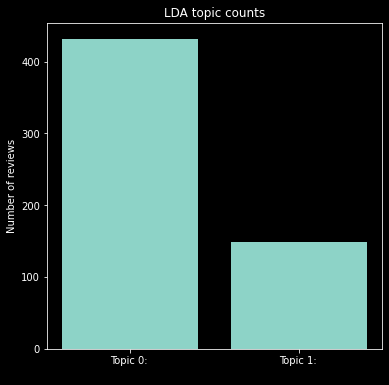

In [ ]:
from collections import Counter
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
lda_keys = []

for n in range(doc_topic.shape[0]):
  lda_keys.append(main_topic(doc_topic, n))
lda_categories, lda_counts = keys_to_counts(lda_keys)
labels = ['Topic {}: \n'.format(i) for i in lda_categories]
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of reviews');